In [1]:
import laspy
import numpy as np

f_1 = laspy.open('data/tree 1.las')
f_1a = laspy.open('data/tree 1A.las')
f_2 = laspy.open('data/tree 2.las')
f_3 = laspy.open('data/tree 3.las')
f_4 = laspy.open('data/tree 4.las')

las_1 = f_1.read()
las_1a = f_1a.read()
las_2 = f_2.read()
las_3 = f_3.read()
las_4 = f_4.read()

names = ['1', '1A', '2', '3', '4']
trees = [las_1, las_1a, las_2, las_3, las_4]

Tree points: 2107351
Tree points: 7492178
Tree points: 3138262
Tree points: 7551511
Tree points: 1436650


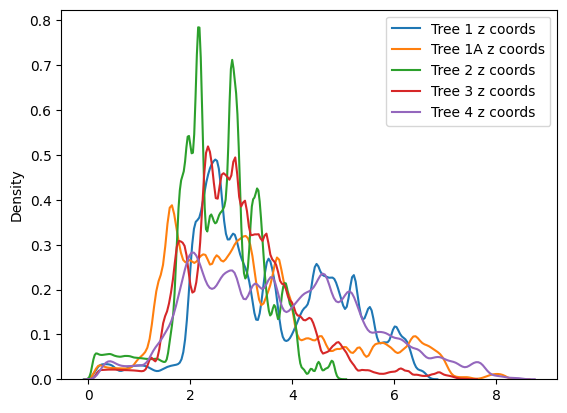

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

for name, las in zip(names, trees):
	print('Tree points:', len(las.points))
	# plt.figure()
	# plt.hist(las.points.z, bins=100, label='z')
	# plt.show()
	sns.kdeplot(las.z.array/1000, label=f'Tree {name} z coords')
plt.legend()
plt.show()

# sns.kdeplot(las_1.z.array/1000, label='tree 1 z coords')

In [4]:
np.set_printoptions(precision=3)

def bounding_box(las: laspy.LasData):
	x_min, x_max = las.x.min(), las.x.max()
	y_min, y_max = las.y.min(), las.y.max()
	z_min, z_max = las.z.min(), las.z.max()
	return np.array([
		[x_min, y_min, z_min],
		[x_max, y_max, z_max]
	])


def centroid(las: laspy.LasData):
	x_mid = (las.x.min() + las.x.max()) / 2
	y_mid = (las.y.min() + las.y.max()) / 2
	z_mid = (las.z.min() + las.z.max()) / 2
	return np.array([x_mid, y_mid, z_mid])


def centroid_dist_from_zero(las: laspy.LasData):
	x_mid, y_mid, z_mid = centroid(las)
	return np.linalg.norm([x_mid, y_mid, z_mid])


def dists_from_zero(las: laspy.LasData):
	return np.linalg.norm([las.x, las.y, las.z], axis=0)


def show_stats(las: laspy.LasData):
	bbox = bounding_box(las)
	centr = centroid(las)

	dists = dists_from_zero(las)
	dist_centr = centroid_dist_from_zero(las).round(3)
	dist_clos = dists.min().round(3)
	dist_furth = dists.max().round(3)
	dist_mean = np.mean(dists).round(3)
	dist_median = np.median(dists).round(3)

	print('Bounding box:\n', bbox)
	print('Centroid:', centr)
	print('Distance of closest point:', dist_clos)
	print('Distance of furthest point:', dist_furth)
	print('Centroid distance from zero:', dist_centr)
	print('Mean distance from zero:', dist_mean)
	print('Median distance from zero:', dist_median)
	print()



for name, las in zip(names, trees):
	print(f'Tree {name}:')
	show_stats(las)

Tree 1:
Bounding box:
 [[-7.218 -3.757  0.131]
 [-4.405 -1.024  6.628]]
Centroid: [-5.812 -2.391  3.38 ]
Distance of closest point: 5.715
Distance of furthest point: 9.38
Centroid distance from zero: 7.135
Mean distance from zero: 7.251
Median distance from zero: 7.186

Tree 1A:
Bounding box:
 [[-2.524 -6.23   0.127]
 [ 1.364 -2.649  8.46 ]]
Centroid: [-0.58  -4.44   4.294]
Distance of closest point: 3.832
Distance of furthest point: 10.113
Centroid distance from zero: 6.203
Mean distance from zero: 5.633
Median distance from zero: 5.318

Tree 2:
Bounding box:
 [[-4.908 -2.374  0.069]
 [-3.192 -0.221  4.933]]
Centroid: [-4.05  -1.298  2.501]
Distance of closest point: 3.835
Distance of furthest point: 6.561
Centroid distance from zero: 4.934
Mean distance from zero: 4.865
Median distance from zero: 4.812

Tree 3:
Bounding box:
 [[ 2.694 -2.413  0.146]
 [ 7.219  1.567  7.493]]
Centroid: [ 4.957 -0.423  3.82 ]
Distance of closest point: 4.039
Distance of furthest point: 9.296
Centroid di

In [23]:
# Mirror the face of the tree that is closest to the origin
def mirror_tree(las: laspy.LasData):
	cx, cy, _ = centroid(las)

	# Translate tree centroid to the origin
	t1 = np.array([
		[1, 0, 0, -cx],
		[0, 1, 0, -cy],
		[0, 0, 1, 0],
		[0, 0, 0, 1]
	])

	# Rotate c to the x axis
	# Meaning that the line orthogonal to c is parallel to the y axis
	# Meaning that we can mirror points by flipping the x coordinate
	# Because we modulo by 2pi, the angle is always positive
	# Points that were closest to the origin end up on the left side of the x axis
	angle = np.cos(cx/cy) % (2*np.pi)
	t2 = np.array([
		[np.cos(angle), -np.sin(angle), 0, 0],
		[np.sin(angle), np.cos(angle),  0, 0],
		[0,             0,              1, 0],
		[0,             0,              0, 1]
	])

	# Flip x coordinate
	t3 = np.array([
		[-1, 0, 0, 0],
		[0, 1, 0, 0],
		[0, 0, 1, 0],
		[0, 0, 0, 1]
	])

	# Rotate back
	t4 = np.array([
		[np.cos(-angle), -np.sin(-angle), 0, 0],
		[np.sin(-angle), np.cos(-angle),  0, 0],
		[0,              0,               1, 0],
		[0,              0,               0, 1]
	])

	# Translate back
	t5 = np.array([
		[1, 0, 0, cx],
		[0, 1, 0, cy],
		[0, 0, 1, 0],
		[0, 0, 0, 1]
	])

	points = np.array([las.x, las.y, las.z, np.ones_like(las.x)]).T

	points_rot = points @ t1 @ t2
	points_filtered = points_rot[points_rot[:,0] <= 0]
	points_mirrored = points_filtered @ t3

	points = np.concatenate([points_rot, points_mirrored], axis=0) @ t4 @ t5
	points_proj = points[:, :3] / points[:, 3, np.newaxis]

	return points_proj




with laspy.open('data/tree 1 mirrored.las', mode='w', header=f_1.header) as f:
	m = mirror_tree(las_1)
	print(m)
	# f.write_points(m)

[[-6.821 -2.683  3.006]
 [-6.    -2.548  0.208]
 [-6.001 -2.55   0.208]
 ...
 [ 0.196  0.514 -0.583]
 [ 0.196  0.514 -0.583]
 [ 0.196  0.514 -0.584]]


In [61]:
# Spacings are in mm at 10m distance from LiDAR

def scan_spacing_of_combined_scans(spacings: list[float]) -> float:
	# Compute density of combined scans
	points_per_m2 = sum(1e6 / spacing**2 for spacing in spacings)

	# If we then (wrongly) assume these points to be uniformly distributed, we can compute the spacing of the combined scan
	return 1 / np.sqrt(points_per_m2)


def scan_spacing_at_distance(spacing_at_10m, dist):
	return dist * spacing_at_10m / 10


def lai(las: laspy.LasData):
	n1 = las.header.point_count
	n2 = mirror_tree(las).shape[0]
	dist = np.median(dists_from_zero(las))

	# 4 scans were taken, one high-res 1.6mm @ 10m, and three at 3.1mm @ 10m
	combined_spacing = scan_spacing_of_combined_scans([1.6e-3, 3.1e-3, 3.1e-3, 3.1e-3])
	spacing = scan_spacing_at_distance(combined_spacing, dist)

	bbox_min, bbox_max = bounding_box(las)
	x, y, z = bbox_max - bbox_min

	print('\tNumber of points:', n1)
	print('\tNumber of mirrored points:', n2)
	print('\tCombined scan spacing:', np.format_float_scientific(combined_spacing, precision=3))
	print('\tCombined scan spacing at distance:', np.format_float_scientific(spacing, precision=3))
	print('\tDimensions:', bbox_max-bbox_min)

	return (n1 * spacing * (x+y)) / (x*y*z)



for name, las in zip(names, trees):
	print('Tree', name)
	print('\tLAI:', lai(las))
	print()

Tree 1
	Number of points: 2107351
	Number of mirrored points: 4214702
	Combined scan spacing: 1.193e-06
	Combined scan spacing at distance: 8.572e-07
	Dimensions: [2.813 2.733 6.497]
	LAI: 0.20056942411775183

Tree 1A
	Number of points: 7492178
	Number of mirrored points: 14984356
	Combined scan spacing: 1.193e-06
	Combined scan spacing at distance: 6.344e-07
	Dimensions: [3.888 3.581 8.333]
	LAI: 0.3059828714997444

Tree 2
	Number of points: 3138262
	Number of mirrored points: 6276524
	Combined scan spacing: 1.193e-06
	Combined scan spacing at distance: 5.740e-07
	Dimensions: [1.716 2.153 4.864]
	LAI: 0.38784489601310834

Tree 3
	Number of points: 7551511
	Number of mirrored points: 7551511
	Combined scan spacing: 1.193e-06
	Combined scan spacing at distance: 6.509e-07
	Dimensions: [4.525 3.98  7.347]
	LAI: 0.31594973038112173

Tree 4
	Number of points: 1436650
	Number of mirrored points: 1436650
	Combined scan spacing: 1.193e-06
	Combined scan spacing at distance: 1.222e-06
	Dimensio